#### Vivian Xia

## Bicycle Doodle GAN

## Load packages

In [ ]:
import os
import numpy as np

import tensorflow
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import RMSprop

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

## Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

os.chdir('/content/drive/My Drive/Colab Notebooks/MSDS462/Quick Draw GAN/')
path_to_file='full_numpy_bitmap_bicycle.npy'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# 28x28 grayscale bitmap in numpy .npy format; images are centered
data = np.load(path_to_file) 

In [ ]:
data.shape #126527 images

(126527, 784)

In [ ]:
# example
data[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  22, 119,   3,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [ ]:
# normalize pixel values and reshape to 28x28
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1))
img_w,img_h = data.shape[1:3]
data.shape

(126527, 28, 28, 1)

In [ ]:
data[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

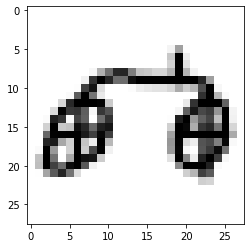

In [ ]:
plt.imshow(data[0,:,:,0], cmap='Greys')

## Create discriminator network

In [ ]:
def discriminator_builder(depth=64,p=0.4): #default depth (# neurons) and proportion for dropout

    # Define inputs
    inputs = Input((img_w,img_h,1)) 
    
    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(inputs) #64 neurons, 5x5 filter, stride length 2x2
    conv1 = Dropout(p)(conv1) #40% dropout
    
    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1) 
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3) 
    conv4 = Flatten()(Dropout(p)(conv4)) #dropout 40% then flatten
    
    # Output layer
    output = Dense(1, activation='sigmoid')(conv4) #only need one output neuron for real/fake and sigmoid to output value between 0 and 1
    
    # Model definition
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [ ]:
discriminator = discriminator_builder()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 256)         0     

In [ ]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0), 
                      metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## Create generator network

In [ ]:
def generator_builder(z_dim=100,depth=64,p=0.4): #define dimensionality of latent space, depth, and proportion for dropout
    
    # Define inputs
    inputs = Input((z_dim,))
    
    # First dense layer
    dense1 = Dense(7*7*64)(inputs) #have 7x7 dimensionality which will become 28x28 after upsampling sever times to make the image larger
    dense1 = BatchNormalization(momentum=0.9)(dense1)
    dense1 = Activation(activation='relu')(dense1) 
    dense1 = Reshape((7,7,64))(dense1) #reshape outputs from 1D dense layer into a 3D shape to pass into the deconvolutional layer
    dense1 = Dropout(p)(dense1)
    
    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1) #7x7 image and upsample it to make it larger
    conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1) 
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    # no upsampling layer here so that the size of image doesn't become too large
    conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output layer 
    output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3) 

    # Model definition    
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [ ]:
generator = generator_builder()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 64)          0         
                                                           

## Create adversarial network

In [ ]:
def adversarial_builder(z_dim=100): 
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0),  #lr and decay is half of what we had in the discriminator
                  metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
adversarial_model = adversarial_builder()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 28, 28, 1)         396961    
                                                                 
 model (Functional)          (None, 1)                 4311553   
                                                                 
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## Train the model

The discriminator is used twice, it's used once on its own to discriminate real from fake images where the weights are being trained in the discriminator. The weights are then frozen with this make trainable function so that as a part of the whole adversarial network the discriminators weights aren't changing, only the weights in the generator are changing.

In [ ]:
def make_trainable(net, val): #neural net and boolean value for if the network is trainable or not
    net.trainable = val
    for l in net.layers: 
        l.trainable = val 

In [ ]:
def train(epochs=2000,batch=128):
    
    #list for discriminator and adversarial netowrk performance
    d_metrics = []
    a_metrics = []
    
    #track loss and accuracy over time
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        # sample real images and fake images
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        #concat to add real and fake images together as inputs
        x = np.concatenate((real_imgs,fake_imgs))
        #label inputs as real and fake respectively
        y = np.ones([2*batch,1]) 
        y[batch:,:] = 0 
        
        make_trainable(discriminator, True)
        
        d_metrics.append(discriminator.train_on_batch(x,y)) #append inputs
        #track running discriminator loss and accuracy 
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1] 
        

        # Freeze discriminator weights so they can't change. 
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y)) #append noise as input
        # track running adversarial loss and accuracy
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        # output every 500 epochs a random sample of outputs from our generator
        if (i+1)%500 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100]) #create random 16 samples from 100-D latent space with the generator
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics


0
100
200
300
400
Epoch #500
499: [D loss: 0.600300, acc: 0.719134]  [A loss: 1.538708, acc: 0.131576]


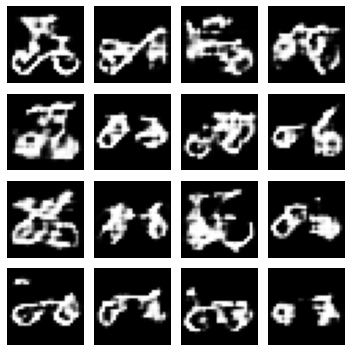

500
600
700
800
900
Epoch #1000
999: [D loss: 0.620418, acc: 0.679062]  [A loss: 1.268608, acc: 0.129090]


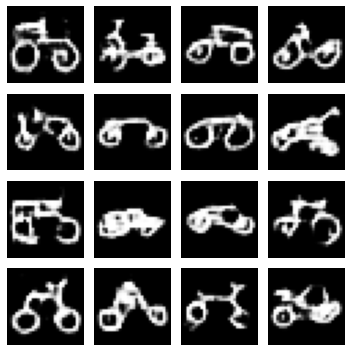

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.624475, acc: 0.669699]  [A loss: 1.229380, acc: 0.130431]


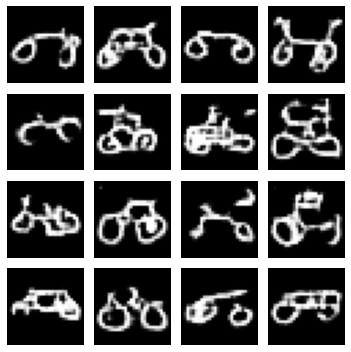

1500
1600
1700
1800
1900
Epoch #2000
1999: [D loss: 0.626411, acc: 0.666550]  [A loss: 1.230359, acc: 0.132605]


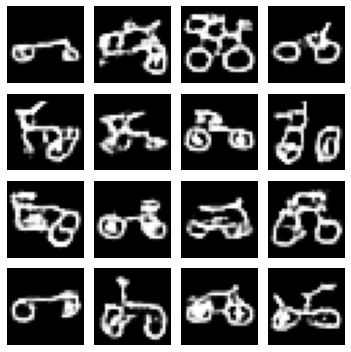

In [ ]:
a_metrics_complete, d_metrics_complete = train(epochs=2000)

Text(0, 0.5, 'Loss')

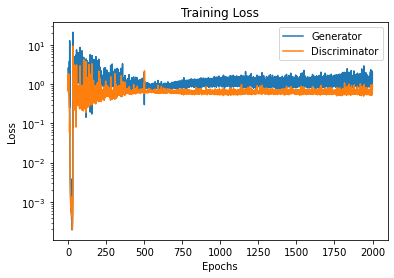

In [ ]:
ax = pd.DataFrame(
    {
        'Generator': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Accuracy')

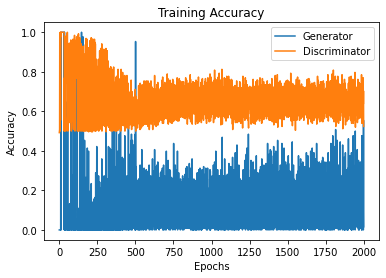

In [ ]:
ax = pd.DataFrame(
    {
        'Generator': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

The generator creates poor fake images in the beginning of training. The discriminator has a really easy job telling real from fake, so the discriminators accuracy is close to a 100% at the beginning.

The generator becomes better at creating fake images, so its accuracy improves. The discriminator has a harder time tell real from fake and so that accuracy comes down.